In [1]:
torch.setdefaulttensortype('torch.FloatTensor')
require 'cutorch'

exact = true
separateParams = false
GPUs = {1}

### Load Cityscapes dataset

In [2]:
package.loaded.cityscapes = nil
cityscapes = require 'cityscapes'

cityscapes.relative = '../../Datasets/Cityscapes/'
nClasses = cityscapes.nClasses -- 19

trainFiles = cityscapes.loadNames('train')
valFiles = cityscapes.loadNames('val')

Loading images from ../../Datasets/Cityscapes/leftImg8bit/train/. Example cities: hanover, zurich	


Loading images from ../../Datasets/Cityscapes/leftImg8bit/val/. Example cities: ., munster	


In [3]:
require 'cunn'
require 'cudnn'

if #GPUs > 1 then
    local function bnparams(self)
       local p, gp = nn.Module.parameters(self)
        p[#p+1] = self.running_mean
        p[#p+1] = self.running_var
        gp[#gp+1] = self.running_mean:clone():zero()
        gp[#gp+1] = self.running_var:clone():zero()
        return p, gp
    end

    torch.getconstructortable('nn.BatchNormalization').parameters = bnparams
    torch.getconstructortable('cudnn.BatchNormalization').parameters = bnparams
end

cudnn.fastest = true
cudnn.benchmark = true

In [4]:
modelName = '000-romera2017'
cityscapes.dsize = {256, 128}

### Render labels for displaying

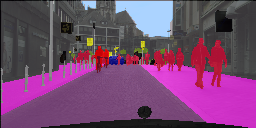

In [5]:
-- example blending
local k = 19
local img, labels = cityscapes.loadSample(trainFiles[k])
itorch.image(cityscapes.renderLabels(labels, img))

In [6]:
intKind = 'IntegralSmartNorm'
_G[intKind] = nil
debug.getregistry()[intKind] = nil 
package.loaded[intKind] = nil

require(intKind)

In [7]:
local modelName = modelName
net = 
    assert(loadfile('Models/' .. modelName .. '.lua'))(cityscapes.dsize[1], cityscapes.dsize[2], nClasses)

if not torch.type(net:get(#net)):find('LogSoftMax') then
    net:add(nn.Contiguous())
    net:add(nn.View(-1, nClasses))
    net:add(nn.LogSoftMax())
end

ints = net:findModules(intKind)
for i = 1,#ints do
    ints[i].normalize = true
    ints[i].exact = exact
    ints[i].saveMemoryIntegral = false
end
print('Number of IntegralSmartNorm modules: ' .. #ints)

net:cuda()
collectgarbage()

Number of IntegralSmartNorm modules: 0	


In [8]:
math.randomseed(666)
torch.manualSeed(666)
if CUDA then cutorch.manualSeed(666) end

if #GPUs > 1 then
    net = nn.DataParallelTable(1, true, true):threads(
        function()
            require 'cudnn'
            require 'IntegralSmartNorm'
        end)
        :cuda():add(net, GPUs)
end

net:reset()

if separateParams then
    params, gradParams = net:parameters()
else
    params, gradParams = net:getParameters()
end

In [9]:
require 'optim'

datasetIdx = 1

if separateParams then
    optimStates = {}

    local intParamsCount = 0

    for i = 1,#params do
        optimStates[i] = {
            learningRate = 1e-3,
            momentum = 0.9,
            nesterov = true,
            dampening = 0,
            learningRateDecay = 0,
            weightDecay = 2e-4
        }

        for k = 1,#ints do
            if 
                params[i] == ints[k].xMin or
                params[i] == ints[k].xMax or
                params[i] == ints[k].yMin or
                params[i] == ints[k].yMax then

                ints[k].params = ints[k].params or {}
                table.insert(ints[k].params, i)

                optimStates[i].weightDecay = 2e-4 -- 0.0185
                optimStates[i].learningRate = optimStates[i].learningRate
                intParamsCount = intParamsCount + 1
                break
            end
        end
    end

    print('Number of IntegralSmartNorm parameter tensors: ' .. intParamsCount)
else
    optimStates = {
        learningRate = 1e-3,
        momentum = 0.9,
        nesterov = true,
        dampening = 0,
        learningRateDecay = 0,
        weightDecay = 2e-4
    }
end

In [10]:
outputDir = 'Cityscapes segmentation/' .. modelName .. '/000-debug/'
os.execute('mkdir "' .. outputDir .. 'Images/train" -p')
os.execute('mkdir "' .. outputDir .. 'Images/val" -p')

In [11]:
-- do return end

for k = 1,#ints do
    for p = 1,ints[k].xMin:nElement() do
        ints[k]:resetSingleWindow(p)
    end
    ints[k].xMin:mul(1.5)
    ints[k].xMax:mul(1.5)
    ints[k].yMin:mul(1.5)
    ints[k].yMax:mul(1.5)
end

In [12]:
-- Load a saved model
do return end
require 'nngraph'
require 'cunn'
require 'cudnn'

net, optimStates = table.unpack(torch.load(outputDir .. 'net.t7'))

if not torch.type(net:get(#net)):find('LogSoftMax') then
    net:add(nn.Contiguous())
    net:add(nn.View(-1, nClasses))
    net:add(nn.LogSoftMax())
end

net:cuda()

local poolings   = net:findModules('nn.SpatialMaxPooling')
local unpoolings = net:findModules('nn.SpatialMaxUnpooling')
for i = 1,#unpoolings do
    unpoolings[i].pooling = poolings[#poolings-i+1]
end

ints = net:findModules(intKind)
for i = 1,#ints do
    ints[i].normalize = true
    ints[i].exact = exact
end

require 'optim'

loaded = true

if #GPUs > 1 then
    net = nn.DataParallelTable(1, true, true):threads(
        function()
            require 'cudnn'
            require 'IntegralSmartNorm'
        end)
        :cuda():add(net, GPUs)
end

if separateParams then
    params, gradParams = net:parameters()
else
    params, gradParams = net:getParameters()
end

datasetIdx = 1

In [13]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

-- ints = {1,1,1,1,1,1,1,1}
wDebs = (#ints > 0) and {} or nil
for k = 1,#ints do wDebs[k] = WindowDebugger() end

In [14]:
require 'optim'

onlineLossLogger = optim.Logger(outputDir .. 'onlineLossLog.log')
evalLogger = optim.Logger(outputDir .. 'evalLog.log')
evalAccLogger = optim.Logger(outputDir .. 'evalAccLog.log')

onlineLossLogger:setNames{'Online batch loss'}
evalLogger:setNames{'Train loss', 'Validation loss'}
evalAccLogger:setNames{
    'Train IoU class', 'Train IoU category',
    'Validation IoU class', 'Validation IoU category'}

onlineLossLogger:style{'-'}
evalLogger:style{'-', '-'}
evalAccLogger:style{'-', '-', '-', '-'}

onlineLossLogger.showPlot = false
evalLogger.showPlot = false
evalAccLogger.showPlot = false

function needToPlot(_onlineLossLogger)
    local plotFreq = 10
    local count = #_onlineLossLogger.symbols[1] + 1
    while count > 1000 do
        plotFreq = plotFreq * 10
        count = count / 10
    end
    
    return #_onlineLossLogger.symbols[1] % plotFreq == 0
end

In [15]:
for k = 1,#ints do
    if wDebs and loaded and paths.filep(outputDir .. 'wd' .. k .. '.t7') then
        wDebs[k]:load(outputDir .. 'wd' .. k .. '.t7')
    end
end

if loaded and paths.filep(outputDir .. 'evalLogger.t7') then
    evalLogger.symbols = torch.load(outputDir .. 'evalLogger.t7')
end
if loaded and paths.filep(outputDir .. 'evalAccLogger.t7') then
    evalAccLogger.symbols = torch.load(outputDir .. 'evalAccLogger.t7')
end
if loaded and paths.filep(outputDir .. 'onlineLossLogger.t7') then
    onlineLossLogger.symbols = torch.load(outputDir .. 'onlineLossLogger.t7')
end

In [16]:
do return end

-- Measure forward/backward propagation time
input = torch.CudaTensor(1, 3, cityscapes.dsize[2], cityscapes.dsize[1]):fill(0.1)
local exactTest = false
net:evaluate()

for k = 1,#ints do
    ints[k].exact = exactTest
end

timer = torch.Timer()
for k = 1,100 do
    net:forward(input)
--     net:backward(input, net.output:clone())
end
cutorch.synchronize()

for k = 1,#ints do
    ints[k].exact = exact
end

print('Average time for 1 forward pass: ' .. (timer:time().real) .. ' seconds. Output size:')
print(net.output:size())

collectgarbage()

In [17]:
criterion = nn.ClassNLLCriterion(cityscapes.classWeights, true, 255):cuda()
-- criterion.nll.ignoreIndex = 255

In [18]:
function comparePredictions(imgIn, labels, prediction, omitOriginal)
    -- tmp buffer for comparePredictions()
    local img = torch.FloatTensor(3, cityscapes.dsize[2], cityscapes.dsize[1])
    img:copy(imgIn)

    img:add(-img:min())
    img:div(img:max())

    local retval

    if omitOriginal then
        retval = torch.ones(3, img:size(2)*2 + 2, img:size(3))

        retval[{{}, {1, img:size(2)}, {}}]:copy(cityscapes.renderLabels(labels, img))
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(cityscapes.renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2)*3 + 4, img:size(3))
        retval[{{}, {1, img:size(2)}, {}}]:copy(img)
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(cityscapes.renderLabels(labels, img, 0.8))
        retval[{{}, {img:size(2)*2+5, retval:size(2)}, {}}]:copy(cityscapes.renderLabels(prediction, img, 0.8))
    end

    collectgarbage()

    return retval
end

In [19]:
-- evaluationIdxVal = {
--     025, 050, 075, 100, 125, 150, 175, 200, 225, 250, 
--     275, 300, 325, 350, 375, 400, 425, 450, 475, 500
-- }
evaluationIdxVal = {}
for k = 1,#valFiles,6 do table.insert(evaluationIdxVal, k) end

evaluationIdxTrain = {
    0150, 0300, 0450, 0600, 0750, 0900, 1050, 1200, 1350, 1500,
    1650, 1800, 1950, 2100, 2250, 2400, 2550, 2700, 2850, 2975
}

-- table.sort(evaluationIdx)

In [25]:
tds = require 'tds'

if not evalLoadPool then
    -- Asynchronous image loading
    threads = require 'threads'
    threads.serialization('threads.sharedserialize')
    threads.Threads.serialization('threads.sharedserialize')
    local nThreads = 6

    -- initialize load worker
    local _dsize, _relative = cityscapes.dsize, cityscapes.relative
    
    evalLoadPool = threads.Threads(
        nThreads,
        function(threadId)
            cityscapes = require 'cityscapes'

            cityscapes.relative = _relative
            cityscapes.dsize = _dsize
            nClasses = cityscapes.nClasses -- 19

            torch.setnumthreads(1)
            cv.setNumThreads{0}

            require 'cutorch'
            cutorch.reserveStreams(1)
            cutorch.setStream(1)
        end,

        function(threadId) end
    )
end

function evaluate(net, files, indices, outPath)
    batchSize = batchSize or 12
    
    if not batch or batch:size(1) ~= batchSize then
        batch = torch.CudaTensor(batchSize, 3, cityscapes.dsize[2], cityscapes.dsize[1])
        batchLabels = torch.CudaLongTensor(batchSize, cityscapes.dsize[1]*cityscapes.dsize[2])

        batchCPU  = cutorch.createCudaHostFloatTensor(batch:size())
        batchCPUR = cutorch.createCudaHostFloatTensor(batch:size()) -- need this for image saving
        batchLabelsCPU  = cutorch.createCudaHostLongTensor(batchLabels:size())
        batchLabelsCPUR = cutorch.createCudaHostLongTensor(batchLabels:size())

        -- for async copy
        batchR, batchLabelsR = batch:clone(), batchLabels:clone()
    end
    
    local batchCPUForSavePool = batchCPU:clone()
    local batchLabelsCPUForSavePool = batchLabelsCPU:clone()
    
    local threadLog = {write=function()end, close=function()end, flush=function()end}
--     local threadLog = io.open(outputDir .. 'threadLogEval.txt', 'w')
    
    local losses = {}
    local avgLoss = 0
    local confMatrix = torch.LongTensor(cityscapes.nClasses, cityscapes.nClasses):zero()
    
    local numSamplesInBatch = tds.AtomicCounter()
    
    local indicesIdx = 1 -- index of current test sample in `indices`
    local batchIndicesR, batchIndices = {}
    
    -- fill first batch
    for k = 1,batchSize do
        if indicesIdx > #indices then break end
        
        table.insert(batchIndicesR, indicesIdx)
        local img, labels = cityscapes.loadSample(files[indices[indicesIdx]])
        batchCPUR[k]:copy(img)
        batchLabelsCPUR[k]:copy(labels)
        
        indicesIdx = indicesIdx + 1
    end
    
    batchR:copy(batchCPUR)
    batchLabelsR:copy(batchLabelsCPUR)
    
    -- initialize save pool
    local _comparePred = comparePredictions
    local _dsize = cityscapes.dsize
    
    local savePool = outPath and threads.Threads(
        evalLoadPool.N,
        function(threadId)
            require 'image'
            cityscapes = require 'cityscapes'
            cityscapes.dsize = _dsize
            
            comparePred = _comparePred
        end,

        function(threadId) end
    )
    
    -- declare to prevent garbage collection at the end of the FOR loop step
    local predictedLabels
    
    while indicesIdx <= #indices do
        
        evalLoadPool:synchronize()
        batch, batchR = batchR, batch
        batchLabels, batchLabelsR = batchLabelsR, batchLabels
        batchCPU, batchCPUR = batchCPUR, batchCPU
        batchLabelsCPU, batchLabelsCPUR = batchLabelsCPUR, batchLabelsCPU
        batchIndicesR, batchIndices = batchIndices, batchIndicesR
        
        numSamplesInBatch:set(0)
        
        batchIndicesR = {}
        local samplesPerThread = math.ceil(batchSize / trainLoadPool.N)
        for threadIdx = 1,trainLoadPool.N do
            local firstBatchIdx = 1 + (threadIdx-1)*samplesPerThread
            local  lastBatchIdx = math.min(threadIdx*samplesPerThread, batchSize)
            local threadSamples = {}
            for _ = firstBatchIdx,lastBatchIdx do
                table.insert(batchIndicesR, indicesIdx)
                table.insert(threadSamples, files[indices[indicesIdx]])
                indicesIdx = indicesIdx + 1
                if indicesIdx > #indices then break end
            end
            
            evalLoadPool:addjob(
                function(samples, startBatchIdx, batchCPU, batchLabelsCPU, batchGPU, batchLabelsGPU, nThreads)

                    for i, sample in ipairs(samples) do
                        local img, labels = cityscapes.loadSample(sample)
                        labels[labels:eq(0)] = 255
                        labels = labels:view(cityscapes.dsize[1]*cityscapes.dsize[2])
                        
                        if torch.random() % 100 == 0 then collectgarbage() end

                        batchCPU[startBatchIdx+i-1]:copy(img)
                        batchLabelsCPU[startBatchIdx+i-1]:copy(labels)
                    end

                    -- check if this thread has done the very last job
                    if numSamplesInBatch:inc() == nThreads-1 then
                        batchGPU:copyAsync(batchCPU)
                        batchLabelsGPU:copyAsync(batchLabelsCPU)
                        cutorch.streamSynchronize(cutorch.getStream())
                    end
                end,
                
                function() end,
                threadSamples, firstBatchIdx, batchCPUR, batchLabelsCPUR, batchR, batchLabelsR, trainLoadPool.N
            )
        end

        local outputs = net:forward(batch):view(batchSize, -1, nClasses)
        
        -- compute loss
        batchLoss = criterion:forward(
            outputs    [{{1, #batchIndices}}]:view(-1, nClasses), 
            batchLabels[{{1, #batchIndices}}]:view(-1))
        -- dirty fix: normalize by the actual batch size (avg loss will be a bit inaccurate)
        batchLoss = batchLoss / #batchIndices * batchSize
        
        if savePool then
            -- the next iteration will fill `batchCPUR`, which may still be read by `savePool`
            -- also, previous `predictedLabels` may also remain used
            savePool:synchronize()
        end
        
        -- evaluate dataset metrics
        predictedLabels = 
            select(2, outputs:view(batchSize, cityscapes.dsize[2], cityscapes.dsize[1], nClasses)
                :max(4)):squeeze():long()
        
        if savePool then
            batchLabelsCPUForSavePool:copy(batchLabelsCPU)
            batchCPUForSavePool:copy(batchCPU)
            
            for k = 1,#batchIndices do
                savePool:addjob(
                    function(idx, input, labels, predictedLabels)
                        image.savePNG(
                            outPath .. string.format('/%04d.png', idx), 
                            comparePred(input, labels, predictedLabels))
                        collectgarbage()
                    end,
                    function() end,

                    batchIndices[k], batchCPUForSavePool[k], batchLabelsCPUForSavePool[k], predictedLabels[k]
                )
            end
        end
        
        cityscapes.updateConfusionMatrix(
            confMatrix,
            predictedLabels[{{1, #batchIndices}}],
            batchLabelsCPU [{{1, #batchIndices}}])
        
        avgLoss = avgLoss + batchLoss
    end
    
    local IoUclassAvg, IoUcategoryAvg = cityscapes.calcIoU(confMatrix)
    
    collectgarbage()
    
    avgLoss = avgLoss / math.ceil(#indices / batchSize)
    
    if savePool then savePool:terminate() end
    threadLog:close()
    
    return avgLoss, IoUclassAvg, IoUcategoryAvg, confMatrix
end

## Training loop

In [26]:
imgPadder = nn.SpatialReplicationPadding(
            cityscapes.dsize[1] * 0.2, cityscapes.dsize[1] * 0.2,
            cityscapes.dsize[2] * 0.2, cityscapes.dsize[2] * 0.2):float()
labelsPadder = imgPadder:clone()

function augment(img, labels)
    if torch.random() % 2 == 0 then
        img = image.flip(img, 3)
        labels = image.flip(labels, 2)
    else
        labels = labels:clone()
    end

    img = imgPadder:forward(img):clone()
    labels = labelsPadder:forward(nn.utils.addSingletonDimension(labels):float()):byte():squeeze()

    local angle = (math.random() * 2 - 1) * 4.5 / 180 * math.pi
    img = image.rotate(img, angle, 'bilinear')
    labels = image.rotate(labels, angle, 'simple')

    local scale = (math.random() * 2 - 1) * 0.11 + 1.0
    img = image.scale(img, '*'..scale, 'bilinear')
    labels = image.scale(labels, '*'..scale, 'simple')

    local extraH, extraW = img:size(2)-cityscapes.dsize[2], img:size(3)-cityscapes.dsize[1]
    if extraH < 0 or extraW < 0 then
        -- upscale
        img = image.scale(img, cityscapes.dsize[1], cityscapes.dsize[2], 'bilinear')
        labels = image.scale(labels, cityscapes.dsize[1], cityscapes.dsize[2], 'simple')
    else
        -- crop
        local padTop, padLeft = math.floor(extraH / 2), math.floor(extraW / 2)
        local cropH, cropW = {1+padTop,padTop+cityscapes.dsize[2]}, {1+padLeft,padLeft+cityscapes.dsize[1]}
        img = img[{{}, cropH, cropW}]:contiguous()
        labels = labels[{cropH, cropW}]:contiguous()
    end
    
    collectgarbage()
    
    return img, labels:long()
end

In [27]:
function copyConvert(obj, t)
   local copy = {}
   for k, v in pairs(obj) do
      if type(v) == 'table' then
         copy[k] = copyConvert(v, t)
      elseif torch.isTensor(v) then
         if k == 'output' or k == 'gradInput' then
            copy[k] = torch.Tensor():type(t)
         else
            copy[k] = v:type(t)
         end
      elseif k == '_type' then
         copy[k] = t
      else
         copy[k] = v
      end
   end
   if torch.typename(obj) then
      torch.setmetatable(copy, torch.typename(obj))
   end
   return copy
end

In [28]:
-- optimStates.learningRate = 1e-3

In [29]:
-- threadLog = io.open(outputDir .. 'threadLog.txt', 'w')
threadLog = {write=function()end, close=function()end, flush=function()end}

batchSize = 12
shuffleEvery = math.ceil(#trainFiles / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 400 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 5 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 800 -- how often to save `net` and `windowDebugger`s

local timer = torch.Timer()

if not trainLoadPool then
    -- Asynchronous image loading
    threads = require 'threads'
    threads.serialization('threads.sharedserialize')
    threads.Threads.serialization('threads.sharedserialize')
    tds = require 'tds'

    local nThreads = 6
    local _dsize, _relative, _augment = cityscapes.dsize, cityscapes.relative, augment
    
    trainLoadPool = threads.Threads(
        nThreads,
        function(threadId)
            require 'image'
            cityscapes = require 'cityscapes'

            torch.setnumthreads(1)
            cv.setNumThreads{0}

            cityscapes.relative = _relative
            cityscapes.dsize = _dsize
            nClasses = cityscapes.nClasses -- 19
            augment = _augment

            imgPadder = nn.SpatialReplicationPadding(
                cityscapes.dsize[1] * 0.2, cityscapes.dsize[1] * 0.2,
                cityscapes.dsize[2] * 0.2, cityscapes.dsize[2] * 0.2):float()
            labelsPadder = imgPadder:clone()

            require 'cutorch'
            cutorch.reserveStreams(1)
            cutorch.setStream(1)
        end,

        function(threadId)
            print('Launching thread #' .. threadId)
        end
    )
end

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,#trainFiles do
    idx[i] = i
end

local avgLoss = 0

net:training()

collectgarbage()

if not batch or batch:size(1) ~= batchSize then
    batch = torch.CudaTensor(batchSize, 3, cityscapes.dsize[2], cityscapes.dsize[1])
    batchLabels = torch.CudaLongTensor(batchSize, cityscapes.dsize[1]*cityscapes.dsize[2])
    
    batchCPU  = cutorch.createCudaHostFloatTensor(batch:size())
    batchCPUR = cutorch.createCudaHostFloatTensor(batch:size()) -- need this for image saving
    batchLabelsCPU  = cutorch.createCudaHostLongTensor(batchLabels:size())
    batchLabelsCPUR = cutorch.createCudaHostLongTensor(batchLabels:size())
    
    -- for async copy
    batchR, batchLabelsR = batch:clone(), batchLabels:clone()
end

for k = 1,batchSize do
    local img, labels = cityscapes.loadSample(trainFiles[idx[datasetIdx]])
    img, labels = augment(img, labels)
    labels[labels:eq(0)] = 255
    labels = labels:view(cityscapes.dsize[1]*cityscapes.dsize[2])
    
    batchCPU[k]:copy(img)
    batchLabelsCPU[k]:copy(labels)
    
    datasetIdx = datasetIdx % #trainFiles + 1
end

batchR:copy(batchCPU)
batchLabelsR:copy(batchLabelsCPU)

local numSamplesInBatch = tds.AtomicCounter()

-- ************** Main loop ***************

for iter = 1,1e9 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    if math.max(iter,1) % (40*outputFreq) == 0 then
        local optimStatesList = separateParams and optimStates or {optimStates}
        for k = 1,#optimStatesList do
            optimStatesList[k].learningRate = optimStatesList[k].learningRate / 2
--             optimStatesList[k].t = 0
--             optimStatesList[k].m:zero()
--             optimStatesList[k].v:zero()
        end
    end
    
    if wDebs and (iter-1) % 200 == 0 then
        for k = 1,#wDebs do
            wDebs[k]:add(ints[k])
        end
    end
    
    if (iter-1) % saveFreq == 0 then
        torch.save(outputDir .. 'net.t7', 
            {copyConvert(#GPUs > 1 and net:get(1) or net, 'torch.FloatTensor'):clearState(), 
            optimStates})
        
        torch.save(outputDir .. 'evalLogger.t7', evalLogger.symbols)
        torch.save(outputDir .. 'evalAccLogger.t7', evalAccLogger.symbols)
        torch.save(outputDir .. 'onlineLossLogger.t7', onlineLossLogger.symbols)
        
        if wDebs then
            for k = 1,#wDebs do
                wDebs[k]:save(outputDir .. 'wd' .. k .. '.t7')
            end
        end
    end
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        threadLog:write('other time: ' .. timer:time().real .. '\n\n'); threadLog:flush(); timer:reset()
        
        -- start filling 'standby' batch
        trainLoadPool:synchronize()
        batch, batchR = batchR, batch
        batchLabels, batchLabelsR = batchLabelsR, batchLabels
        
        threadLog:write('sync time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
        
        numSamplesInBatch:set(0)
        
        local samplesPerThread = math.ceil(batchSize / trainLoadPool.N)
        for threadIdx = 1,trainLoadPool.N do
            local firstBatchIdx = 1 + (threadIdx-1)*samplesPerThread
            local  lastBatchIdx = math.min(threadIdx*samplesPerThread, batchSize)
            local threadSamples = {}
            for _ = firstBatchIdx,lastBatchIdx do
                table.insert(threadSamples, trainFiles[idx[datasetIdx]])
                datasetIdx = datasetIdx % #trainFiles + 1
            end
            
            trainLoadPool:addjob(
                function(samples, startBatchIdx, batchCPU, batchLabelsCPU, batchGPU, batchLabelsGPU, nThreads)
    
                    for i, sample in ipairs(samples) do
                        local img, labels = cityscapes.loadSample(sample)
                        img, labels = augment(img, labels)
                        labels[labels:eq(0)] = 255
                        labels = labels:view(cityscapes.dsize[1]*cityscapes.dsize[2])
                        
                        if torch.random() % 100 == 0 then collectgarbage() end

                        batchCPU[startBatchIdx+i-1]:copy(img)
                        batchLabelsCPU[startBatchIdx+i-1]:copy(labels)
                    end
                    
                    -- check if this thread has done the very last job
                    if numSamplesInBatch:inc() == nThreads-1 then
                        batchGPU:copyAsync(batchCPU)
                        batchLabelsGPU:copyAsync(batchLabelsCPU)
                        cutorch.streamSynchronize(cutorch.getStream())
                    end
                end,
                
                function() end,
                threadSamples, firstBatchIdx, batchCPU, batchLabelsCPU, batchR, batchLabelsR, trainLoadPool.N
            )
        end
        threadLog:write('stby batch fill time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
        
        net:forward(batch) -- 2 x 13999 x 19
        batchLoss = criterion:forward(net.output:view(-1, nClasses), batchLabels:view(-1))
        net:zeroGradParameters()
        criterion:backward(net.output:view(-1, nClasses), batchLabels:view(-1))
        net:backward(batch, criterion.gradInput:view(batchSize,-1,nClasses)) -- accumulate gradients
        
        threadLog:write('fwd+bwd exec time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
    end -- do
    
    -- detect NaNs
    function hasNaN(x) return x:ne(x):sum() > 0 end
    if batchLoss ~= batchLoss then -- or hasNaN(net.output) then
        print('Loss is NaN')
        break
    end
    
    onlineLossLogger:add{batchLoss}
    if needToPlot(onlineLossLogger) then onlineLossLogger:plot() end

    -- optimization step
    if separateParams then
        for i = 1,#params do
            local feval = function(x)
                return batchLoss, gradParams[i]
            end
            optim.adam(feval, params[i], optimStates[i])
        end
    else
        local feval = function(x)
            return batchLoss, gradParams
        end
        optim.adam(feval, params, optimStates)
    end
    threadLog:write('opt time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
    
    if iter % 100 == 0 then collectgarbage() end
    
    if (iter-1) % outputFreq == 0 then
        net:evaluate()
        
        local trainLoss, trainIOUclass, trainIOUcategory = 
            evaluate(net, trainFiles, evaluationIdxTrain,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/train/'))
        
        local valLoss, valIOUclass, valIOUcategory = 
            evaluate(net, valFiles, evaluationIdxVal,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/val/'))
        
        collectgarbage()
        
        evalLogger:add{trainLoss, valLoss}
        evalAccLogger:add{trainIOUclass, trainIOUcategory, valIOUclass, valIOUcategory}
        evalLogger:plot()
        evalAccLogger:plot()
        
        net:training()
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
    
    collectgarbage()
end

threadLog:close()

if wDebs then
    for k = 1,#wDebs do
        wDebs[k]:save(outputDir .. 'wd' .. k .. '.t7')
    end
end

collectgarbage()

Epoch 0	

In [5]:
local optimStatesList = separateParams and optimStates or {optimStates}
for k = 1,#optimStatesList do
    optimStatesList[k].learningRate = optimStatesList[k].learningRate / 2
end

In [27]:
1e-3 / optimStates.learningRate

0.66666666666667	


In [2]:
-- do this after INTERRUPTing
torch.save(outputDir .. 'net.t7', {copyConvert(#GPUs > 1 and net:get(1) or net, 'torch.FloatTensor'):clearState(), optimStates})

torch.save(outputDir .. 'evalLogger.t7', evalLogger.symbols)
torch.save(outputDir .. 'evalAccLogger.t7', evalAccLogger.symbols)
torch.save(outputDir .. 'onlineLossLogger.t7', onlineLossLogger.symbols)

if wDebs then
    for k = 1,#wDebs do
        wDebs[k]:exportVideo(outputDir .. 'int-layer-' .. k .. '.avi')
    end
end

## Export images for evaluation by `cityscapesScripts`

In [34]:
local timer = torch.Timer()
net:evaluate()
print(net.train)

valLoss, valIOUclass, valIOUcategory = evaluate(net, valFiles, evaluationIdxVal, outputDir .. 'Images/val/')
print(valIOUclass, valIOUcategory)

net:training()
print(timer:time().real .. ' seconds')

false	


0.094279417915172	0.19964675951217	


3.3136148452759 seconds	


In [3]:
net:evaluate()

function getResultFilename(s)
    local slashIdx = s:find('/')
    s = s:sub(slashIdx+1, -1)
    local slashIdx = s:find('/')
    s = s:sub(slashIdx+1, -1)
    local slashIdx = s:find('/')
    return s:sub(slashIdx+1, -16) .. 'result.png'
end

print('Total ' .. #valFiles)

os.execute('mkdir "' .. cityscapes.relative .. 'results" -p')
local input = torch.CudaTensor()

for k = 1,#valFiles do
    if k % 50 == 0 then print(k) end
    
    local img, labels = cityscapes.loadSample(valFiles[k])

    input:resize(img:size())
    input:copy(img)
    local outputs = net:forward(nn.utils.addSingletonDimension(input)):squeeze()
    local outLabels = 
        select(2, outputs:float():view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses)
            :max(3)):squeeze()
    local outLabelsEval = cityscapes.labelsToEval(outLabels)
    
--     itorch.image(outLabelsEval)
    image.savePNG(
        cityscapes.relative .. 'results/' .. getResultFilename(valFiles[k].image), 
        image.scale(outLabelsEval, 2048, 1024, 'simple'))
end

net:training()

Total 500	


50	


100	


150	


200	


250	


300	


350	

400	


450	


500	
